<a href="https://colab.research.google.com/github/eubrunoread/InvestigaDados/blob/main/notebook/Plotagem_Mapa_CSV_Google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**SOLUÇÃO PARA PLOTAGEM NO MAPA DE DADOS DE GEOREFERENCIAMENTO EM FORMATO CSV**
----
*Desenvolvido pelo Agente PCSC **Bruno Bevilaqua Lemos** como parte de um projeto pessoal de aprendizagem de Phyton, sugestões ou correções podem ser enviadas para bruno-lemos@pc.sc.gov.br*

----

*Para rodar código pressione CTRL+F9, ou vá clicando no botão 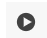 em cada célula.*

-----
Este código faz o upload, processamento e visualização de um arquivo CSV contendo dados geográficos (latitude e longitude), além de criar um mapa interativo com marcadores e um trajeto traçado, utilizando a biblioteca Folium e a funcionalidade AntPath para visualização.

### ***Fluxo geral:***

1. O usuário faz upload de um ou mais arquivos CSV com colunas 'Latitude', 'Longitude' e 'DataHora'.

2. O script lê, ordena, e adiciona marcadores no mapa com a sequência temporal dos dados.

3. Um trajeto é desenhado entre os pontos, e o mapa interativo é salvo e baixado como HTML.

In [ ]:
import pandas as pd
import folium
from google.colab import files
from folium.plugins import AntPath, FeatureGroupSubGroup

#**Upload do arquivo CSV**

Faça o uploado do arquivo CSV.

In [ ]:
# Faz o upload dos arquivos CSV
uploaded = files.upload()

for fn in uploaded.keys():
  print('Upload do arquivo "{name}" com o tamanho de {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Reverse Location (1).csv to Reverse Location (1).csv
Saving Reverse Location (2).csv to Reverse Location (2).csv
Saving Reverse Location (3).csv to Reverse Location (3).csv
Saving Reverse Location.csv to Reverse Location.csv
Upload do arquivo "Reverse Location (1).csv" com o tamanho de 1242 bytes
Upload do arquivo "Reverse Location (2).csv" com o tamanho de 3626 bytes
Upload do arquivo "Reverse Location (3).csv" com o tamanho de 8002 bytes
Upload do arquivo "Reverse Location.csv" com o tamanho de 1680 bytes


In [ ]:
#Cria a lista para guardar as tabelas
df = []

# Processar cada arquivo
for arquivo in uploaded.keys():
    print(f'\nProcessando o arquivo: {arquivo}')
    # Processar cada arquivo
    conteudo_csv = pd.read_csv(arquivo, sep=',', header=0)
    df.append(conteudo_csv)

df = pd.concat(df, ignore_index=True, sort=False)

# Tratamento e Conversão da Data e Hora para formato DateTime
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')

coluna_hora = next((col for col in df.columns if col.startswith('Time ')), None)

df['Hora'] = df[coluna_hora].str.split(' ', expand=True)[0]

df['DataHora'] = pd.to_datetime(df['Date'].dt.strftime('%Y/%m/%d') + ' ' + df['Hora'], format='%Y/%m/%d %H:%M:%S')

df = df.drop(columns=['Date', 'Time (America/Argentina/Catamarca)', 'Hora'])

# Ordenar por Data e Hora, e cria uma coluna com a sequencia temporal
df['DataHora'] = pd.to_datetime(df['DataHora'], format='%d/%m/%Y %H:%M:%S')

df_ordenado = df.sort_values(by='DataHora', ascending=True).reset_index(drop=True)
df_ordenado['SequenciaTemporal'] = df_ordenado.index + 1  # Começando o indexador em 1
df_ordenado
df


Processando o arquivo: Reverse Location (1).csv

Processando o arquivo: Reverse Location (2).csv

Processando o arquivo: Reverse Location (3).csv

Processando o arquivo: Reverse Location.csv


,Reverse Location Obfuscated ID,Latitude,Longitude,Source,Maps display radius(m),DataHora
0,010101BD56354D92B51E1E0CE1ACD964AB54D7C71A0AA4...,-27.444301,-52.327696,WIFI,23,2024-07-07 20:54:32
1,010101BD56354D7AF356BE92BCFDBD11B8CDC4E6CA7E9C...,-27.444370,-52.327463,WIFI,11,2024-07-07 20:52:14
2,010101BD56354DA5150419242B20810BB78C4065A4ACA0...,-27.444359,-52.327587,WIFI,14,2024-07-07 20:52:34
3,010101BD56354D7AF356BE92BCFDBD11B8CDC4E6CA7E9C...,-27.444366,-52.327522,WIFI,17,2024-07-07 20:48:04
4,010101BD56354DCDAD79A3FFB7243EE7DC1F809C840291...,-27.444318,-52.327668,WIFI,26,2024-07-07 20:54:22
...,...,...,...,...,...,...
95,010101BD56354DA5150419242B20810BB78C4065A4ACA0...,-27.444200,-52.329754,WIFI,32,2024-07-07 20:46:30
96,010101BD56354DE6E7FEBBC53B199F548E9544FB781E9E...,-27.443819,-52.329856,WIFI,100,2024-07-07 20:49:10
97,010101BD56354D9BFDEB46942F6355AA156D6FB47DC824...,-27.443918,-52.329561,UNKNOWN,56,2024-07-07 20:45:27
98,010101BD56354D1C905C64253722339FBE07A763341B56...,-27.443742,-52.329575,UNKNOWN,13,2024-07-07 20:45:35


In [ ]:
# Criar um mapa centrado na primeira estação
mapa = folium.Map(location=[df['Latitude'].iloc[0], df['Longitude'].iloc[0]], zoom_start=10)

In [ ]:
# Cores disponíveis no folium
cores_disponiveis = ['white', 'lightgray', 'gray', 'lightblue', 'beige', 'blue', 'darkred', 'lightgreen',
                     'purple', 'red', 'green', 'lightred', 'white', 'darkblue', 'darkpurple',
                     'cadetblue', 'orange', 'pink', 'lightgray', 'darkgreen', 'black']

# Inicializar o mapa
mapa = folium.Map(location=[df_ordenado['Latitude'].mean(), df_ordenado['Longitude'].mean()], zoom_start=13)

# Criar um FeatureGroup para os marcadores
fg_marcadores = folium.FeatureGroup(name="Marcadores").add_to(mapa)

# Agrupar coordenadas por 'Reverse Location Obfuscated ID'
coordenadas_por_id = {}

for index, row in df_ordenado.iterrows():
    id = row['Reverse Location Obfuscated ID']
    if id not in coordenadas_por_id:
        coordenadas_por_id[id] = []
    coordenadas_por_id[id].append([row['Latitude'], row['Longitude']])

# Variáveis para rastrear a posição atual nas listas de cores
cor_marcador_index = 0
cor_icone_index = 0

# Adicionar AntPath e marcadores agrupados por ID
for id, coordenadas in coordenadas_por_id.items():
    # Atribuir cores atuais
    cor_marcador = cores_disponiveis[cor_marcador_index]
    cor_icone = cores_disponiveis[cor_icone_index]

    # Atualizar índices para as próximas combinações
    cor_icone_index += 1
    if cor_icone_index >= len(cores_disponiveis):
        cor_icone_index = 0
        cor_marcador_index = (cor_marcador_index + 1) % len(cores_disponiveis)

    # Criar subgrupo para cada ID
    subgrupo = FeatureGroupSubGroup(fg_marcadores, name=id)

    # Adicionar AntPath ao subgrupo
    AntPath(coordenadas, color=cor_icone, weight=5).add_to(subgrupo)

    # Adicionar marcadores ao subgrupo
    for coord in coordenadas:
        folium.Marker(
            location=coord,
            popup=id,
            icon=folium.Icon(icon='phone', color=cor_marcador, icon_color=cor_icone)
        ).add_to(subgrupo)

    # Adicionar subgrupo ao mapa
    mapa.add_child(subgrupo)

# Adicionar controle Filtros ao mapa
folium.LayerControl(collapsed=False).add_to(mapa)

# Exibir o mapa
mapa

## **Download do Arquivo**

In [28]:
# Salvar o mapa como um arquivo HTML
output_filename = f"MAPA_GOOGLE_{arquivo.rsplit('.', 1)[0]}.html"
mapa.save(output_filename)
files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>